## Imports and configuration

In [176]:
%matplotlib notebook

import fiona
from shapely.geometry import shape
from shapely.ops import transform as trans

import rasterio
import rasterio.mask
from rasterio.merge import merge as rmerge
from rasterio.plot import show as rshow
from rasterio import plot as rplt

from pyproj import Proj, transform

from fastai import *
from fastai.vision import *

import requests
import os

data_path = Path('./data')
train_shp_path = data_path/'train'/'train.shp'
crop_labels_df = pd.read_csv(data_path/'Farmpin_training.csv')
crop_labels_human_df = pd.read_csv(data_path/'crop_id_list.csv')

## Load and Combine Rasters for each date and time

### Define function to combine rasters given by paths and band, optionally plot result

In [179]:
def merge_rasters(jep_path, jfp_path, band_code, plot_result=False):
    
    # set up paths to load files from
    date_code = img_path_jep.parts[1].split('_')[2]
    jep_file_name = 'T34JEP_%s_%s.jp2' % (date_code, band_code)
    jfp_file_name = 'T34JFP_%s_%s.jp2' % (date_code, band_code)
    src_paths = [jep_path/jep_file_name,
                 jfp_path/jfp_file_name]
    
    # set up path to save merged file to
    mosaic_file_name = "%s_%s_merged.tif" % (date_code, band_code)
    mosaic_file_path = data_path/mosaic_file_name

    # load the component files
    src_files_to_mosaic = []
    for fp in src_paths:
        src = rasterio.open(fp, driver='JP2OpenJPEG')
        src_files_to_mosaic.append(src)

    # merge them, configure the metadata, and write the merged file to disk
    mosaic, out_trans = rmerge(src_files_to_mosaic)
    out_meta = src.meta.copy()    
    out_meta.update({"driver": "GTiff",
                     "height": mosaic.shape[1],
                     "width": mosaic.shape[2],
                     "transform": out_trans})
    with rasterio.open(mosaic_file_path, "w", **out_meta) as dest1:
        dest1.write(mosaic)

    # display the merged file
    if (plot_result):
        rshow(mosaic, cmap='pink')

    return mosaic_file_path

### Example for 2017-01-01 data, B12 band

<IPython.core.display.Javascript object>


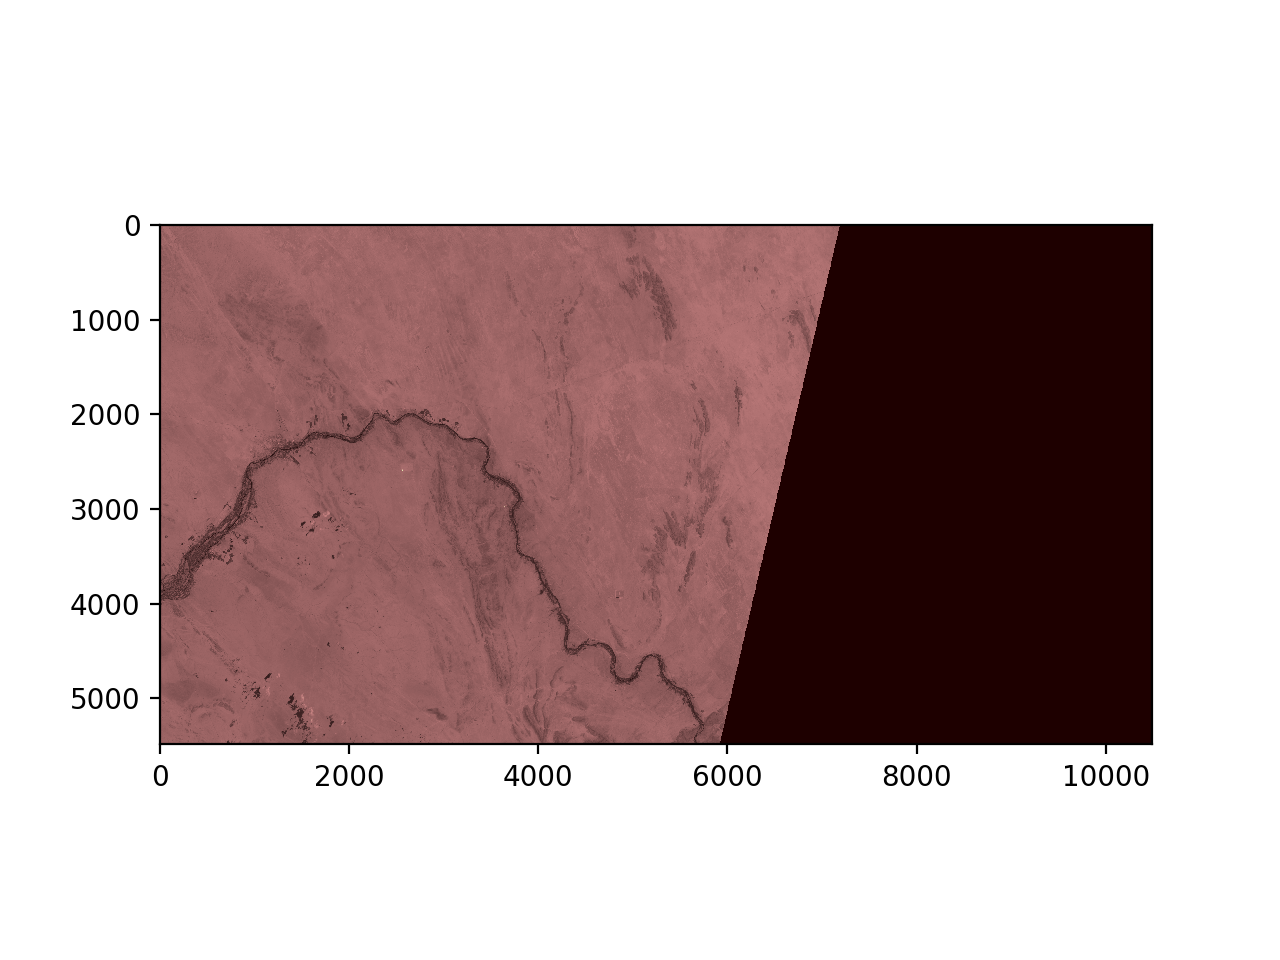

In [180]:
img_path_jep = data_path/'S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE'/'GRANULE'/'L1C_T34JEP_A007983_20170101T084543'/'IMG_DATA'
img_path_jfp = data_path/'S2A_MSIL1C_20170101T082332_N0204_R121_T34JFP_20170101T084543.SAFE'/'GRANULE'/'L1C_T34JFP_A007983_20170101T084543'/'IMG_DATA'
merged_file_path = merge_rasters(img_path_jep, img_path_jfp, 'B12', plot_result=True)

## Slice out fields for each band and date/time

### Calculate the projections needed.

In [100]:
# Load the shapes and capture the original projection spec
with fiona.open(train_shp_path, "r") as shapefile:
    features = [feature for feature in shapefile if feature['geometry']] # three items with 'geometry': None
    shape_proj_orig = Proj(shapefile.crs)

# Read the projection of the raster file
with rasterio.open(merged_file_path) as dest_proj_src:
    shape_proj_dest = Proj(dest_proj_src.crs)
    shape_meta_dest = dest_proj_src.meta['crs']

def plot_transformed_coords(coords):
    x = [i[0] for i in coords]
    y = [i[1] for i in coords]
    x, y = transform(shape_proj_orig, shape_proj_dest, x, y)
    plt.plot(x, y)
    
print("Transforming shapes from %s to %s" % (shape_proj_orig, shape_proj_dest))

Transforming shapes from pyproj.Proj('+proj=merc +lon_0=0 +lat_ts=0 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs=True ', preserve_units=True) to pyproj.Proj('+units=m +init=epsg:32734 ', preserve_units=True)


### View all training shapes overlaid on raster

<IPython.core.display.Javascript object>


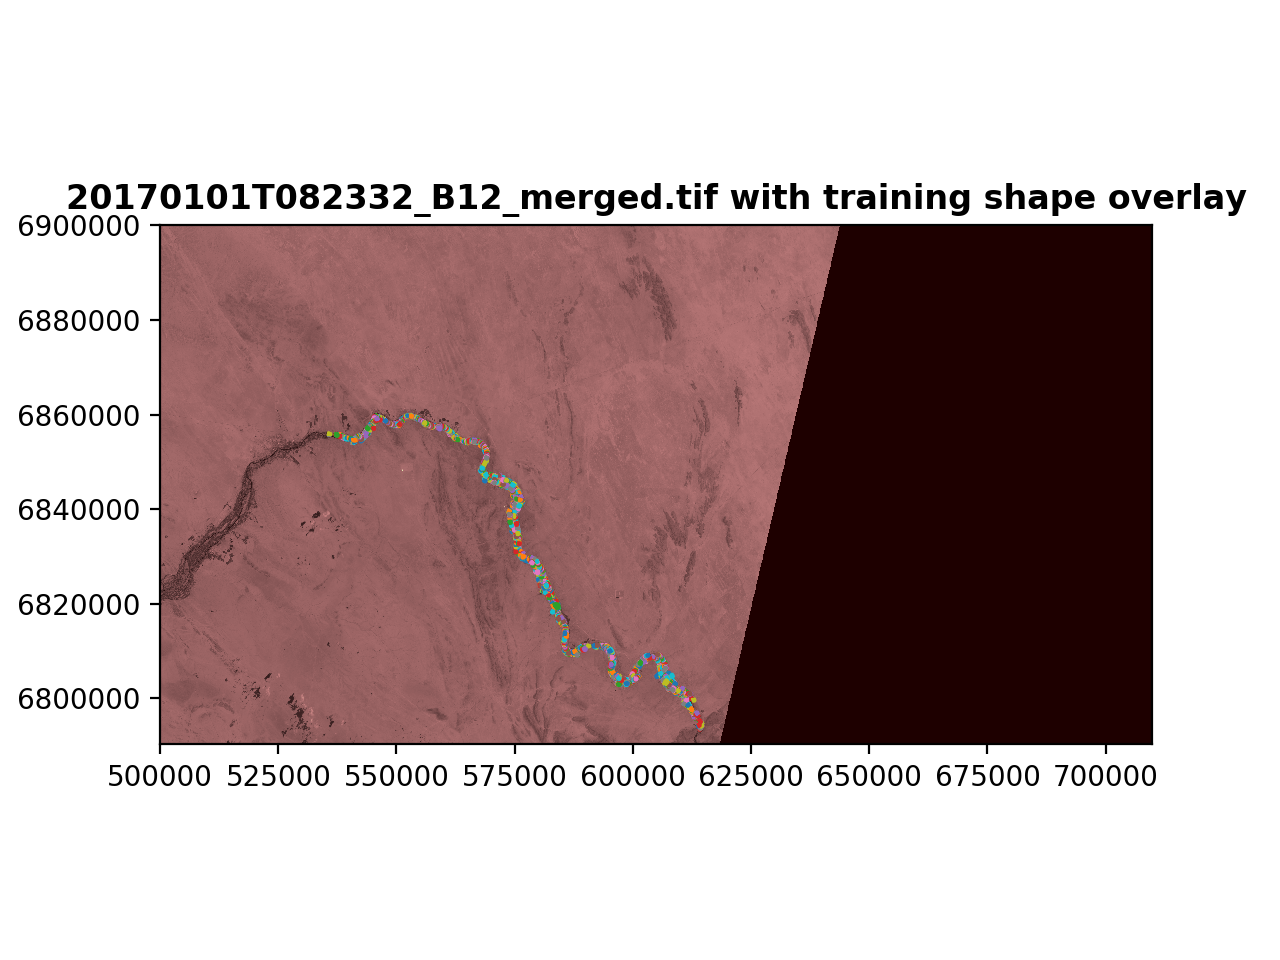

In [150]:
def plot_shapes_over_raster(shape_idxs=[]):
    plt.figure()

    # Plot vectors shapes
    for idx, f in enumerate(features):
        if not shape_idxs or idx in shape_idxs: # if user doesn't provide ids, plot all
            if f['geometry']: # 3 field shapes in training set without geometry
                if f['geometry']['type'] == 'MultiPolygon':
                    for coord in f['geometry']['coordinates'][0][:]:
                        plot_transformed_coords(coord)
                else:
                    plot_transformed_coords(f['geometry']['coordinates'][0][:])

    # Plot merged raster
    with rasterio.open(merged_file_path) as img:
        rplt.show(img, cmap="pink", title="%s with training shape overlay" % (merged_file_path.name))

    plt.show()
    
plot_shapes_over_raster()

### View single training shape sliced from raster

In [193]:
def get_shape(idx=None):
    if not idx:
        idx = int(random.random() * len(features))
    shp = shape(features[idx]['geometry'])

    project = partial(
        transform,
        shape_proj_orig, # source coordinate system
        Proj(shape_meta_dest)) # destination coordinate system

    shp_trans = trans(project, shp)  # apply projection
    
    return idx, shp_trans

/home/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `item` has been deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


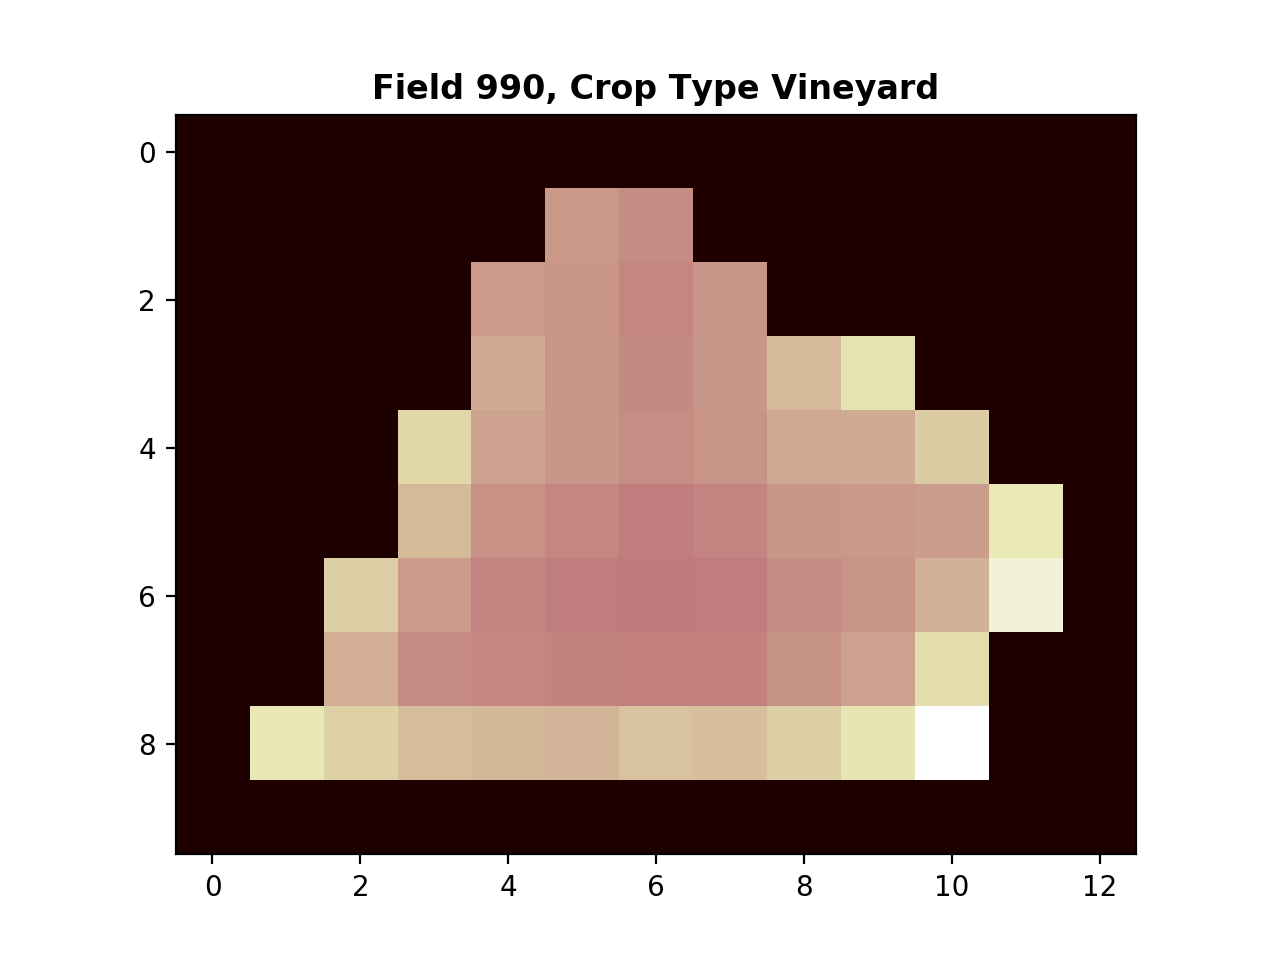

In [197]:
%matplotlib notebook

def draw_field(field_idx):
    with rasterio.open(merged_file_path) as img:
        # Run the mask
        out_image, out_transform = rasterio.mask.mask(img, [get_shape(field_idx)[1]], crop=True)

        # Grab the details of the field
        field_id = features[field_idx]['properties']['Field_Id']
        crop_name = crop_labels_human_df.loc[crop_labels_human_df['crop_id'] == int(features[field_idx]['properties']['Crop_Id_Ne'])]['crop'].item()

        # Plot
        show(out_image, cmap="pink", title="Field %s, Crop Type %s" % (field_id, crop_name))
        
        return out_image

def draw_random_field():
    
    # Grab a new random shape
    idx_rand, shp_rand = get_shape()
    
    return draw_field(idx_rand), idx_rand, shp_rand

        
        
out_image, idx_rand, shp_rand = draw_random_field()

<IPython.core.display.Javascript object>


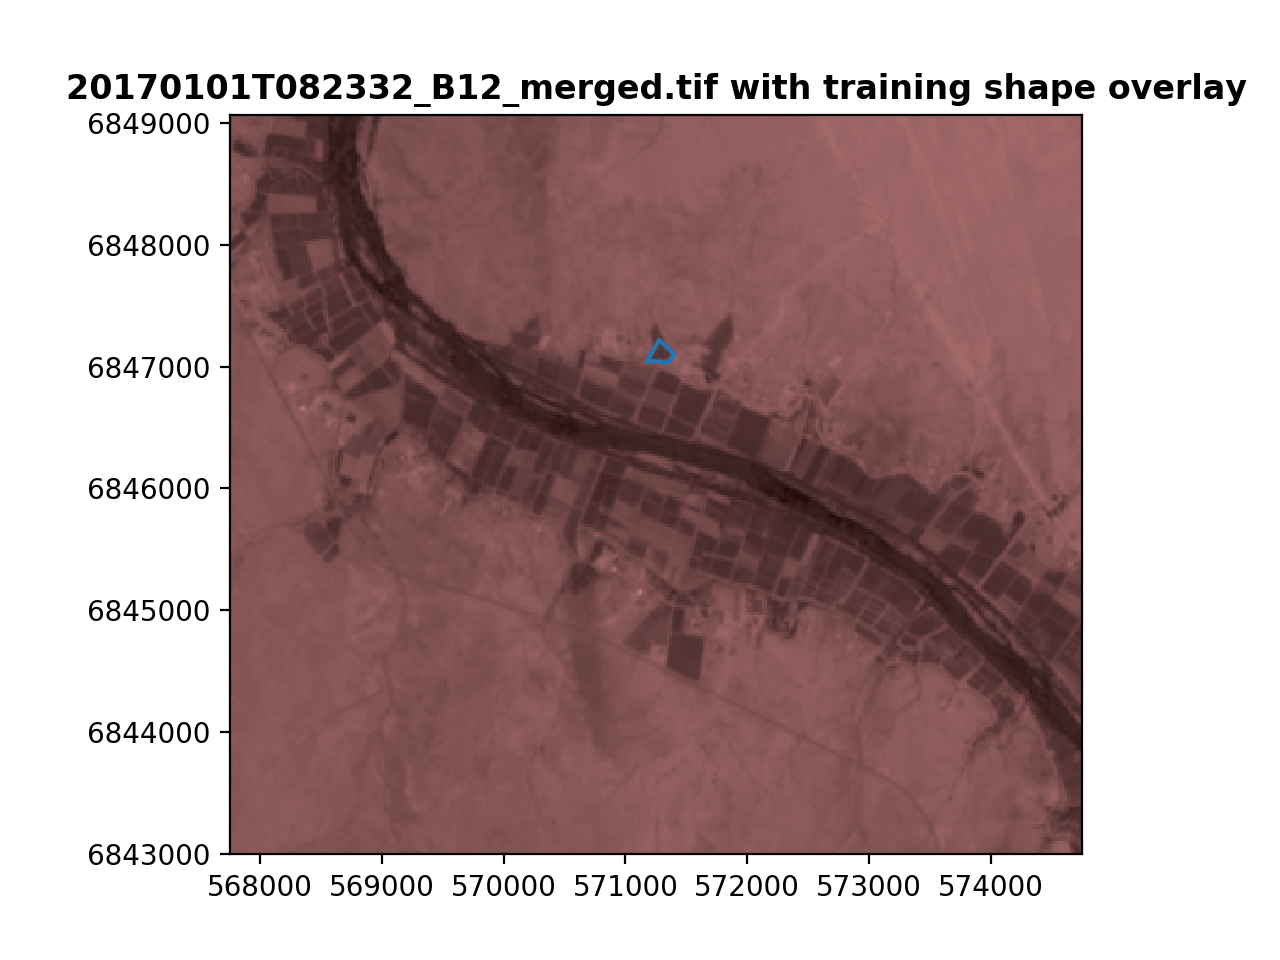

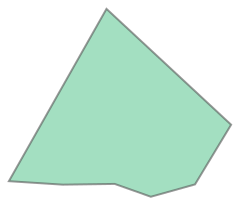

In [198]:
plot_shapes_over_raster([idx_rand])
shp_rand

In [213]:
out_image[0]

array([[   0,    0,    0,    0, ...,    0,    0,    0,    0],
       [   0,    0,    0,    0, ...,    0,    0,    0,    0],
       [   0,    0,    0,    0, ...,    0,    0,    0,    0],
       [   0,    0,    0,    0, ..., 1669,    0,    0,    0],
       ...,
       [   0,    0, 1469, 1036, ...,  993, 1220, 1988,    0],
       [   0,    0, 1182,  928, ..., 1078, 1617,    0,    0],
       [   0, 1731, 1491, 1308, ..., 1704, 2319,    0,    0],
       [   0,    0,    0,    0, ...,    0,    0,    0,    0]], dtype=uint16)

## Get a random field's values across all bands